# Import dependencies

In [3]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.data.load_root import load_root
from utils.data.build_graph import build_graphs
from utils.data.load_graphs import load_graphs
from utils.evaluation.evaluate_graphs import evaluate_data, evaluate_graphs
from utils.plotting.plot_events import plot_information, plot_event
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.training.train_3 import train_model
from utils.evaluation.evaluate_model import evaluate_model


# Import Root data

In [4]:
%%time
load_rootdata = False

if load_rootdata:
    path = "~/Documents/Masterarbeit/Panda_Software/PandaRoot/dev/source/macro/data/evtcomplete"
    raw = load_root(path, showentries=True)
    raw.to_hdf('data/raw.h5', key='df', mode='w')  

else:
    raw = pd.read_hdf('data/raw.h5', 'df')  

CPU times: user 105 ms, sys: 109 ms, total: 213 ms
Wall time: 212 ms


Choose number of events to be analysed

In [5]:
run = 'final_fullgraph'
run_title = 'full graph'

nevents = raw.index.max()
nevents = 1000
node_dim = 2
edge_dim = 2

# Investigate raw data

In [5]:
%%time

show=False
if show:
   
    plot_information(raw, name=run, nevents=30000).plot_ntracks_nhits()
    evID=np.random.randint(nevents)
    evID = 3
    event = raw.loc[raw.index==evID]
    plot_event(event, scale=1.8, name=run).plot_eventdisplay()
    
    data_eval = evaluate_data(raw, ncuts=50, nevents=30000, name=run)
    data_eval.curler_dist()

    purity, efficiency, cuts, cutPos, TNR, FNR = data_eval.find_pzcut()
    data = plot_information(name=run, nevents=nevents)
    data.plot_purity_efficiency(
        cuts, 
        25, 
        purity, 
        efficiency, 
        TNR, 
        FNR, 
        nevents, 
        variable = r'$p_z^{min}$', 
        unit= 'GeV/c',
        xname = r'$p_z^{min}$ (GeV/c)', 
        yname = 'purity & efficiency', 
        save_name = f'img/3_pz_threshold_{run}.pdf')

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 5.01 µs


# Graph building for training

In [6]:
in_dir = 'data/graphs'

pz_min = 0.001
slope_max = 1.
minlayer=0
maxlayer=24

graph_dir = f'{in_dir}_{run}_pzmin_{pz_min}_slopemax_{slope_max}'

In [7]:
%%time

data = build_graphs(raw,end=30000, shuffle=True,  pz_min=pz_min, remove_duplicates=True, slope=slope_max, graph_dir=graph_dir)
create_g = False

if create_g:
    graphs = data.create_graph_list(node_dim=node_dim, edge_dim=edge_dim, minlayer=minlayer, maxlayer=maxlayer)
    print(f'graphs saved to {graph_dir}')

    Nedges, Ntrue = 0,0     
    for g in graphs:
        Nedges += len(g.y)
        Ntrue += sum(g.y)
    print(f'Nedges: {Nedges}, Ntrue: {Ntrue}, Ntrue/Nedges: {Ntrue/Nedges}, meanNedges: {Nedges/nevents}')
    
else:
    graphs = load_graphs(graph_dir, n_graphs=nevents, node_dim=node_dim, edge_dim=edge_dim) #load n random sample graphs

#show preprocessed data
data.events.sort_index()

Nedges: 163256, Ntrue: 96668, Ntrue/Nedges: 0.5921252511393149
Nnodes: 103084, Nedges/Nnodes: 1.5837181327849132
CPU times: user 2.58 s, sys: 369 ms, total: 2.95 s
Wall time: 2.93 s


,hit_id,particle_id,x,z,iso,pz,chamber_id,skewed,layer_id,layer,Hit_id
event_id,,,,,,,,,,,
0,547,2,29.542500,309.390015,0.380595,7.657896,1,0,7,3,106
0,20378,2,71.457497,654.364685,0.103020,7.614486,6,0,48,24,148
0,727353,0,27.522499,437.489990,0.119575,2.421842,4,0,25,13,221
0,1283618,3,-32.067501,653.489990,0.158261,7.700203,6,0,47,23,99
0,1944183,0,18.937500,327.769684,0.309845,2.432236,2,0,10,6,206
...,...,...,...,...,...,...,...,...,...,...,...
29999,933381,3,5.807500,423.839691,0.037754,5.498756,3,0,24,12,120
29999,623789,0,5.302500,653.489990,0.086463,7.105002,6,0,47,23,239
29999,1988600,5,7.827500,342.264679,0.104802,1.379045,2,0,16,8,15


# Evaluate Graph building
for comparison with original raw data choose evaluate_graphs(data.raw.rename(columns={'layer_id':'layer'}), graphs).evaluate_graphs()

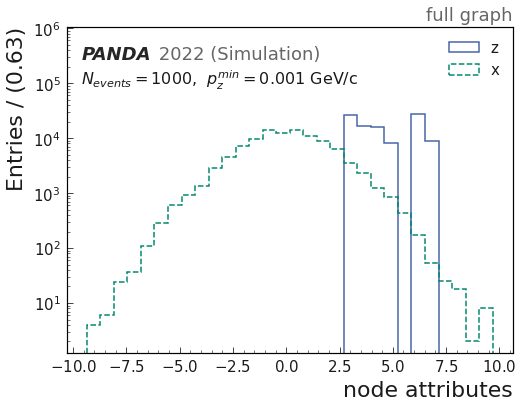

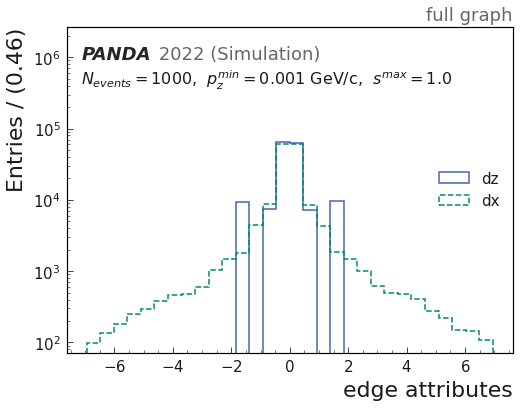

In [20]:
test_samples = 1000
show_graph_dims = False

if show_graph_dims:
    show_infos = plot_information(graphs=graphs[:test_samples], pz_min=pz_min, slope_max=slope_max, name=run, title=run_title)
    show_infos.plot_graph_data_info(bins=30, log=True)

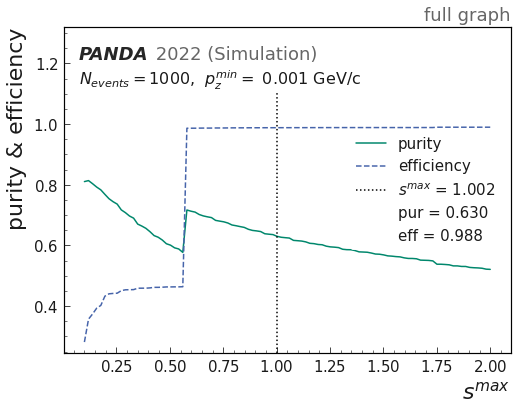

best pz threshold at 1.0020, removed bad (TNR): 0.988, lost good (FNR): 0.012


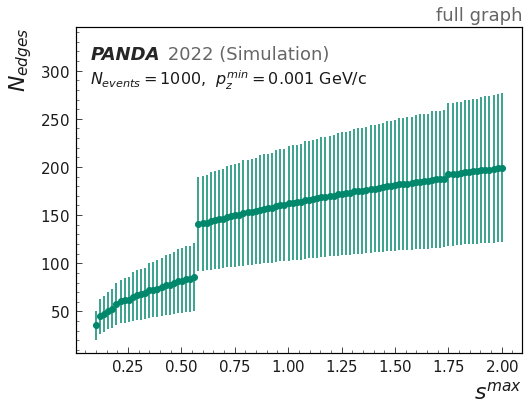

CPU times: user 1.02 s, sys: 276 ms, total: 1.3 s
Wall time: 994 ms


In [25]:
%%time
evaluate_gb = False
test_samples = 1000
ncuts = 100

if evaluate_gb:
        
    testdata = build_graphs(raw,end=test_samples, shuffle=True, pz_min=pz_min, remove_duplicates=True, slope=slope_max)
    slope = np.linspace(0.1,2,ncuts)
    purities, efficiencies, TNRs, FNRs = np.zeros((4,ncuts))
    nnodes, nedges = [], []
           
    for i, s in enumerate(tqdm(slope)):
        testdata.slope = s
        testgraphs = testdata.create_graph_list(show_progress=False, node_dim=2, edge_dim=2, minlayer=minlayer, maxlayer=maxlayer)
        purity, efficiency, TNR, FNR, _ = evaluate_graphs(testdata.events, testgraphs, name=run).evaluate_graphs(show_progress=False)
        purities[i] = purity
        efficiencies[i] = efficiency
        TNRs[i] = TNR
        FNRs[i] = FNR
        
        ne = []
        
        for g in testgraphs:
            ne.append(len(g.y))
        nedges.append([np.mean(ne), np.std(ne)])
    nn = []
    for g in testgraphs:
        nn.append(len(g.x))
    nnodes = [np.mean(nn), np.std(nn)]
    print(f'average number of nodes: {nnodes[0]:.2f} with standard deviation {nnodes[1]:.2f}')
    nedges = np.array(nedges)
        
                
    show_infos = plot_information(graphs=graphs[:test_samples], pz_min=pz_min, slope_max=slope_max, name=run, title=run_title)
    cutPos = np.argmin(np.abs(np.array(purities)-np.array(efficiencies)))
    cutPos = 47

    show_infos.plot_purity_efficiency(
        cuts=slope, 
        cut_pos=cutPos, 
        purity=purities, 
        efficiency=efficiencies, 
        TNR=TNRs, 
        FNR=FNRs, 
        nevents=test_samples, 
        variable=r'$s^{max}$',
        xname=r'$s^{max}$', 
        yname='purity & efficiency', 
        save_name=f'img/3_graphbuilding_purity_efficiency_{run}.pdf', 
        add_inf=r',  $p_z^{min} =$ '+f'{pz_min:.3f} GeV/c',
        legloc='center right', 
        scale=1.38)
        
    
    show_infos.plot_graph_dimensions(nnodes, nedges, slope, test_samples)

# Plot Graphs

In [42]:
%%time
# evID = np.random.randint(nevents)
evID = 3
plot_graphs=False
    
if plot_graphs:    

    hits = data.events.loc[evID]
    graph = graphs[evID]

    plotevent = plot_event(hits, graph=graph, shift=.14, scale=1.6, name=run, title=run_title)
    # plotevent.plot_eventdisplay()
    plotevent.plot_graphdisplay(pz_min=pz_min, slope_max=slope_max, show_slope=True, colormap='magma', reverse_cm=False)


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


# Prepare Training

In [8]:
# torch.manual_seed(42)
device = 'cpu'
hidden_size = 16
lr = 0.0006555334907620447
gamma = 0.8562969741310678
epochs = 40
patience = 10
step_size = 3

name = f'IN_nevents_{nevents}_hidden_{hidden_size}_lr_{lr}_gamma_{gamma}_steps_{step_size}'


In [9]:
batch_size = 1
parts = [0.8, 0.1, 0.1] #sizes of training, validation and testing samples
load_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 16}

parts = np.cumsum((nevents*np.array(parts)).astype(int))
partition = {'train': graphs[:parts[0]],  
             'test':  graphs[parts[0]:parts[1]],
             'val': graphs[parts[1]:parts[2]]}


train_set = GraphDataset(partition['train'])
train_loader = DataLoader(train_set, **load_params)
test_set = GraphDataset(partition['test'])
test_loader = DataLoader(test_set, **load_params)
val_set = GraphDataset(partition['val'])
val_loader = DataLoader(val_set, **load_params)

In [131]:
model = InteractionNetwork(node_dim, edge_dim, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

model.count_parameters()

InteractionNetwork(node_dim: 2, edge_dim: 2, hidden_size: 16)
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |     96     |
|  R1.layers.0.bias  |     16     |
| R1.layers.2.weight |    256     |
|  R1.layers.2.bias  |     16     |
| R1.layers.4.weight |     32     |
|  R1.layers.4.bias  |     2      |
| O.layers.0.weight  |     64     |
|  O.layers.0.bias   |     16     |
| O.layers.2.weight  |    256     |
|  O.layers.2.bias   |     16     |
| O.layers.4.weight  |     32     |
|  O.layers.4.bias   |     2      |
| R2.layers.0.weight |     96     |
|  R2.layers.0.bias  |     16     |
| R2.layers.2.weight |    256     |
|  R2.layers.2.bias  |     16     |
| R2.layers.4.weight |     16     |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 1205


# Training

In [132]:
results = train_model(
    train_loader, 
    val_loader, 
    model, 
    optimizer, 
    scheduler, 
    device=device,
    epochs=epochs, 
    patience=patience, 
    run=run,
    name=name
)


  0%|                                                                                                            | 0/40 [00:00<?, ?it/s]

Train Epoch: 1, epoch time: 5.15s
Mean Train Batch Loss: 0.4147


  2%|██▌                                                                                                 | 1/40 [00:06<04:02,  6.21s/it]


 Validation set: Average loss: 0.2577
, Accuracy: 0.8948

Validation loss decreased (inf --> 0.257671).  Saving model ...
Train Epoch: 2, epoch time: 5.17s
Mean Train Batch Loss: 0.2593


  5%|█████                                                                                               | 2/40 [00:12<03:54,  6.18s/it]


 Validation set: Average loss: 0.2283
, Accuracy: 0.9083

Validation loss decreased (0.257671 --> 0.228268).  Saving model ...
Train Epoch: 3, epoch time: 5.11s
Mean Train Batch Loss: 0.2348


  8%|███████▌                                                                                            | 3/40 [00:18<03:47,  6.16s/it]


 Validation set: Average loss: 0.2137
, Accuracy: 0.9187

Validation loss decreased (0.228268 --> 0.213713).  Saving model ...
Train Epoch: 4, epoch time: 5.03s
Mean Train Batch Loss: 0.2181


 10%|██████████                                                                                          | 4/40 [00:24<03:39,  6.11s/it]


 Validation set: Average loss: 0.1929
, Accuracy: 0.9219

Validation loss decreased (0.213713 --> 0.192866).  Saving model ...
Train Epoch: 5, epoch time: 5.15s
Mean Train Batch Loss: 0.2093


 12%|████████████▌                                                                                       | 5/40 [00:30<03:34,  6.13s/it]


 Validation set: Average loss: 0.1978
, Accuracy: 0.9193

EarlyStopping counter: 1 out of 10
Train Epoch: 6, epoch time: 5.24s
Mean Train Batch Loss: 0.2034


 15%|███████████████                                                                                     | 6/40 [00:36<03:29,  6.17s/it]


 Validation set: Average loss: 0.1819
, Accuracy: 0.9241

Validation loss decreased (0.192866 --> 0.181871).  Saving model ...
Train Epoch: 7, epoch time: 5.23s
Mean Train Batch Loss: 0.1970


 18%|█████████████████▌                                                                                  | 7/40 [00:43<03:24,  6.20s/it]


 Validation set: Average loss: 0.1805
, Accuracy: 0.9279

Validation loss decreased (0.181871 --> 0.180474).  Saving model ...
Train Epoch: 8, epoch time: 5.07s
Mean Train Batch Loss: 0.1936


 20%|████████████████████                                                                                | 8/40 [00:49<03:16,  6.15s/it]


 Validation set: Average loss: 0.1827
, Accuracy: 0.9273

EarlyStopping counter: 1 out of 10
Train Epoch: 9, epoch time: 5.04s
Mean Train Batch Loss: 0.1903


 22%|██████████████████████▌                                                                             | 9/40 [00:55<03:09,  6.12s/it]


 Validation set: Average loss: 0.1833
, Accuracy: 0.9275

EarlyStopping counter: 2 out of 10
Train Epoch: 10, epoch time: 5.09s
Mean Train Batch Loss: 0.1853


 25%|████████████████████████▊                                                                          | 10/40 [01:01<03:03,  6.11s/it]


 Validation set: Average loss: 0.1689
, Accuracy: 0.9306

Validation loss decreased (0.180474 --> 0.168947).  Saving model ...
Train Epoch: 11, epoch time: 5.27s
Mean Train Batch Loss: 0.1830


 28%|███████████████████████████▏                                                                       | 11/40 [01:07<02:58,  6.16s/it]


 Validation set: Average loss: 0.1658
, Accuracy: 0.9300

Validation loss decreased (0.168947 --> 0.165778).  Saving model ...
Train Epoch: 12, epoch time: 5.11s
Mean Train Batch Loss: 0.1813


 30%|█████████████████████████████▋                                                                     | 12/40 [01:13<02:52,  6.15s/it]


 Validation set: Average loss: 0.1659
, Accuracy: 0.9285

EarlyStopping counter: 1 out of 10
Train Epoch: 13, epoch time: 5.22s
Mean Train Batch Loss: 0.1802


 32%|████████████████████████████████▏                                                                  | 13/40 [01:20<02:47,  6.19s/it]


 Validation set: Average loss: 0.1630
, Accuracy: 0.9311

Validation loss decreased (0.165778 --> 0.162978).  Saving model ...
Train Epoch: 14, epoch time: 5.13s
Mean Train Batch Loss: 0.1783


 35%|██████████████████████████████████▋                                                                | 14/40 [01:26<02:40,  6.18s/it]


 Validation set: Average loss: 0.1610
, Accuracy: 0.9328

Validation loss decreased (0.162978 --> 0.161031).  Saving model ...
Train Epoch: 15, epoch time: 5.16s
Mean Train Batch Loss: 0.1770


 38%|█████████████████████████████████████▏                                                             | 15/40 [01:32<02:34,  6.18s/it]


 Validation set: Average loss: 0.1581
, Accuracy: 0.9316

Validation loss decreased (0.161031 --> 0.158138).  Saving model ...
Train Epoch: 16, epoch time: 5.09s
Mean Train Batch Loss: 0.1758


 40%|███████████████████████████████████████▌                                                           | 16/40 [01:38<02:28,  6.18s/it]


 Validation set: Average loss: 0.1582
, Accuracy: 0.9326

EarlyStopping counter: 1 out of 10
Train Epoch: 17, epoch time: 5.19s
Mean Train Batch Loss: 0.1751


 42%|██████████████████████████████████████████                                                         | 17/40 [01:44<02:22,  6.20s/it]


 Validation set: Average loss: 0.1585
, Accuracy: 0.9318

EarlyStopping counter: 2 out of 10
Train Epoch: 18, epoch time: 5.21s
Mean Train Batch Loss: 0.1746


 45%|████████████████████████████████████████████▌                                                      | 18/40 [01:51<02:16,  6.21s/it]


 Validation set: Average loss: 0.1604
, Accuracy: 0.9336

EarlyStopping counter: 3 out of 10
Train Epoch: 19, epoch time: 5.14s
Mean Train Batch Loss: 0.1736


 48%|███████████████████████████████████████████████                                                    | 19/40 [01:57<02:10,  6.20s/it]


 Validation set: Average loss: 0.1569
, Accuracy: 0.9329

Validation loss decreased (0.158138 --> 0.156912).  Saving model ...
Train Epoch: 20, epoch time: 5.03s
Mean Train Batch Loss: 0.1730


 50%|█████████████████████████████████████████████████▌                                                 | 20/40 [02:03<02:02,  6.14s/it]


 Validation set: Average loss: 0.1557
, Accuracy: 0.9334

Validation loss decreased (0.156912 --> 0.155654).  Saving model ...
Train Epoch: 21, epoch time: 5.16s
Mean Train Batch Loss: 0.1729


 52%|███████████████████████████████████████████████████▉                                               | 21/40 [02:09<01:57,  6.17s/it]


 Validation set: Average loss: 0.1553
, Accuracy: 0.9322

Validation loss decreased (0.155654 --> 0.155296).  Saving model ...
Train Epoch: 22, epoch time: 5.21s
Mean Train Batch Loss: 0.1723


 55%|██████████████████████████████████████████████████████▍                                            | 22/40 [02:15<01:51,  6.19s/it]


 Validation set: Average loss: 0.1559
, Accuracy: 0.9341

EarlyStopping counter: 1 out of 10
Train Epoch: 23, epoch time: 5.09s
Mean Train Batch Loss: 0.1716


 57%|████████████████████████████████████████████████████████▉                                          | 23/40 [02:21<01:44,  6.17s/it]


 Validation set: Average loss: 0.1546
, Accuracy: 0.9328

Validation loss decreased (0.155296 --> 0.154578).  Saving model ...
Train Epoch: 24, epoch time: 5.16s
Mean Train Batch Loss: 0.1712


 60%|███████████████████████████████████████████████████████████▍                                       | 24/40 [02:28<01:38,  6.19s/it]


 Validation set: Average loss: 0.1561
, Accuracy: 0.9317

EarlyStopping counter: 1 out of 10
Train Epoch: 25, epoch time: 5.07s
Mean Train Batch Loss: 0.1708


 62%|█████████████████████████████████████████████████████████████▉                                     | 25/40 [02:34<01:32,  6.17s/it]


 Validation set: Average loss: 0.1545
, Accuracy: 0.9340

Validation loss decreased (0.154578 --> 0.154499).  Saving model ...
Train Epoch: 26, epoch time: 5.17s
Mean Train Batch Loss: 0.1705


 65%|████████████████████████████████████████████████████████████████▎                                  | 26/40 [02:40<01:26,  6.18s/it]


 Validation set: Average loss: 0.1547
, Accuracy: 0.9342

EarlyStopping counter: 1 out of 10
Train Epoch: 27, epoch time: 5.15s
Mean Train Batch Loss: 0.1704


 68%|██████████████████████████████████████████████████████████████████▊                                | 27/40 [02:46<01:20,  6.18s/it]


 Validation set: Average loss: 0.1539
, Accuracy: 0.9342

Validation loss decreased (0.154499 --> 0.153940).  Saving model ...
Train Epoch: 28, epoch time: 5.21s
Mean Train Batch Loss: 0.1699


 70%|█████████████████████████████████████████████████████████████████████▎                             | 28/40 [02:52<01:14,  6.22s/it]


 Validation set: Average loss: 0.1544
, Accuracy: 0.9342

EarlyStopping counter: 1 out of 10
Train Epoch: 29, epoch time: 5.09s
Mean Train Batch Loss: 0.1694


 72%|███████████████████████████████████████████████████████████████████████▊                           | 29/40 [02:58<01:07,  6.18s/it]


 Validation set: Average loss: 0.1536
, Accuracy: 0.9326

Validation loss decreased (0.153940 --> 0.153621).  Saving model ...
Train Epoch: 30, epoch time: 5.11s
Mean Train Batch Loss: 0.1696


 75%|██████████████████████████████████████████████████████████████████████████▎                        | 30/40 [03:05<01:01,  6.19s/it]


 Validation set: Average loss: 0.1530
, Accuracy: 0.9332

Validation loss decreased (0.153621 --> 0.153015).  Saving model ...
Train Epoch: 31, epoch time: 5.19s
Mean Train Batch Loss: 0.1691


 78%|████████████████████████████████████████████████████████████████████████████▋                      | 31/40 [03:11<00:55,  6.18s/it]


 Validation set: Average loss: 0.1529
, Accuracy: 0.9346

Validation loss decreased (0.153015 --> 0.152869).  Saving model ...
Train Epoch: 32, epoch time: 5.10s
Mean Train Batch Loss: 0.1689


 80%|███████████████████████████████████████████████████████████████████████████████▏                   | 32/40 [03:17<00:49,  6.14s/it]


 Validation set: Average loss: 0.1535
, Accuracy: 0.9332

EarlyStopping counter: 1 out of 10
Train Epoch: 33, epoch time: 5.24s
Mean Train Batch Loss: 0.1688


 82%|█████████████████████████████████████████████████████████████████████████████████▋                 | 33/40 [03:23<00:43,  6.18s/it]


 Validation set: Average loss: 0.1525
, Accuracy: 0.9342

Validation loss decreased (0.152869 --> 0.152473).  Saving model ...
Train Epoch: 34, epoch time: 5.20s
Mean Train Batch Loss: 0.1686


 85%|████████████████████████████████████████████████████████████████████████████████████▏              | 34/40 [03:29<00:37,  6.21s/it]


 Validation set: Average loss: 0.1518
, Accuracy: 0.9334

Validation loss decreased (0.152473 --> 0.151833).  Saving model ...
Train Epoch: 35, epoch time: 5.24s
Mean Train Batch Loss: 0.1684


 88%|██████████████████████████████████████████████████████████████████████████████████████▋            | 35/40 [03:36<00:31,  6.23s/it]


 Validation set: Average loss: 0.1519
, Accuracy: 0.9340

EarlyStopping counter: 1 out of 10
Train Epoch: 36, epoch time: 5.14s
Mean Train Batch Loss: 0.1684


 90%|█████████████████████████████████████████████████████████████████████████████████████████          | 36/40 [03:42<00:24,  6.22s/it]


 Validation set: Average loss: 0.1517
, Accuracy: 0.9348

Validation loss decreased (0.151833 --> 0.151749).  Saving model ...
Train Epoch: 37, epoch time: 5.10s
Mean Train Batch Loss: 0.1680


 92%|███████████████████████████████████████████████████████████████████████████████████████████▌       | 37/40 [03:48<00:18,  6.19s/it]


 Validation set: Average loss: 0.1517
, Accuracy: 0.9339

Validation loss decreased (0.151749 --> 0.151687).  Saving model ...
Train Epoch: 38, epoch time: 5.19s
Mean Train Batch Loss: 0.1680


 95%|██████████████████████████████████████████████████████████████████████████████████████████████     | 38/40 [03:54<00:12,  6.18s/it]


 Validation set: Average loss: 0.1516
, Accuracy: 0.9335

Validation loss decreased (0.151687 --> 0.151646).  Saving model ...
Train Epoch: 39, epoch time: 5.15s
Mean Train Batch Loss: 0.1679


 98%|████████████████████████████████████████████████████████████████████████████████████████████████▌  | 39/40 [04:00<00:06,  6.19s/it]


 Validation set: Average loss: 0.1524
, Accuracy: 0.9346

EarlyStopping counter: 1 out of 10
Train Epoch: 40, epoch time: 5.11s
Mean Train Batch Loss: 0.1676


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [04:07<00:00,  6.18s/it]


 Validation set: Average loss: 0.1558
, Accuracy: 0.9346

EarlyStopping counter: 2 out of 10


# Evaluate Training

In [15]:
# output_name = 'train_IN_1000_16_0.00055334907620447_0.8562969741310678_3.npy'
# train_output_dir = 'train_output'

# train_output = np.load(os.path.join(train_output_dir, output_name), allow_pickle=True).item()
# model = torch.load(files[31])

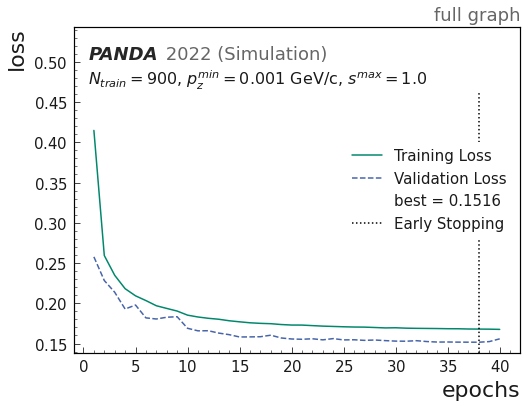

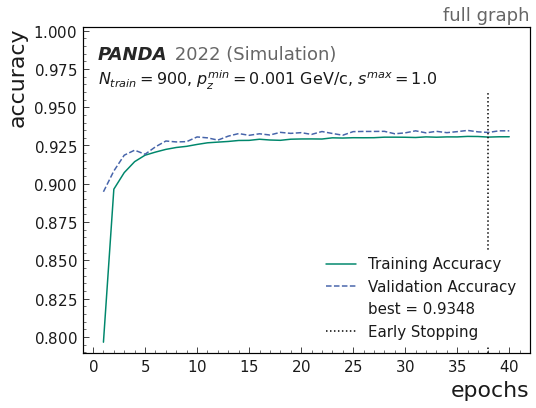

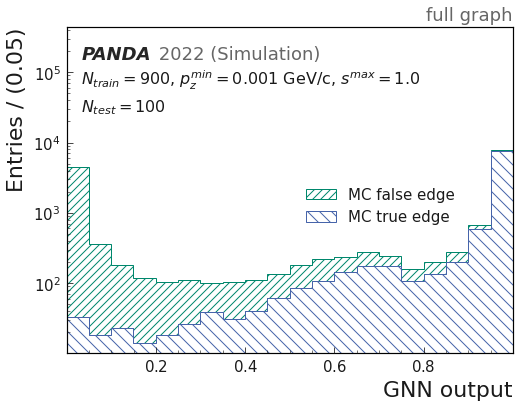

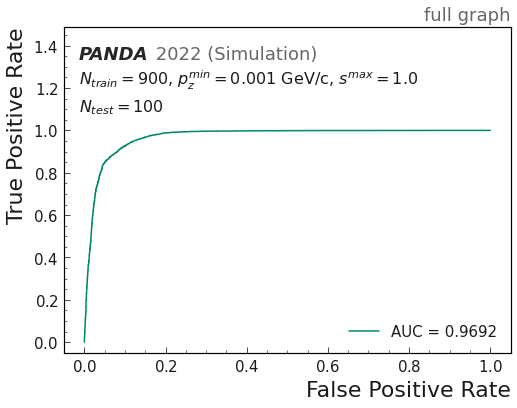

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 13382.38it/s]


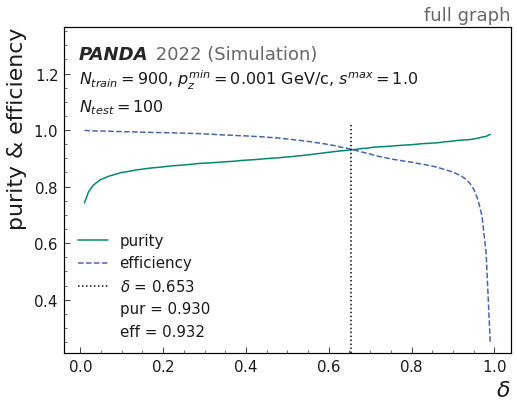

best $\delta$ threshold at 0.6534, removed bad (TNR): 0.896, lost good (FNR): 0.068


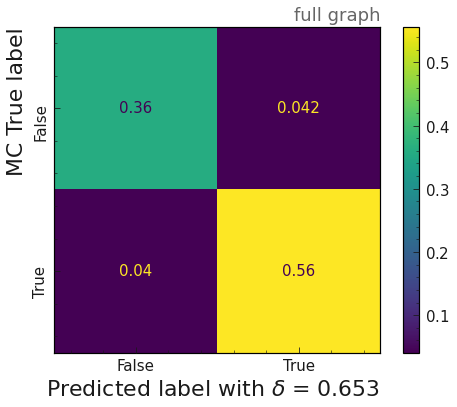

In [184]:
model, train_output = results.trained

threshold = 0.7
evaluation = evaluate_model(model, test_loader, pz_min, slope_max, int(nevents*0.9), train_output, threshold, ncuts=100, name=run, title=run_title)
evaluation.plot_loss()
evaluation.plot_acc()
evaluation.plot_metrics(output_bins=20, scale=1.5)


# Show Results

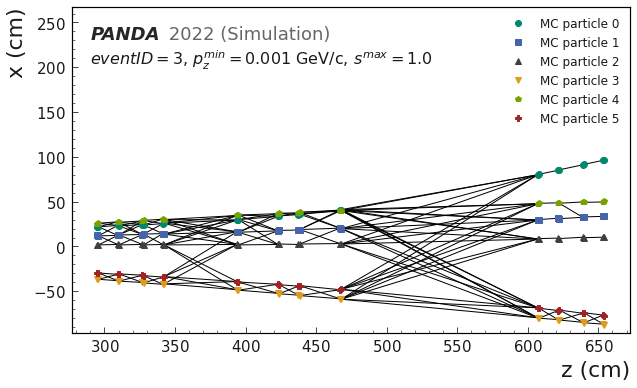

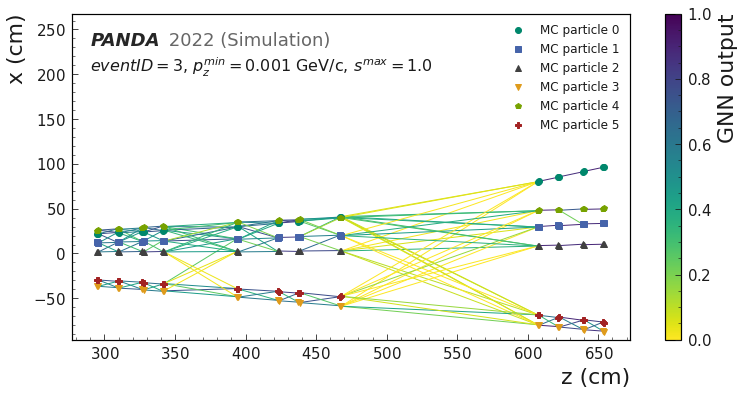

In [17]:
plot_event(hits, graph, scale=1.8, name=run+'_black').plot_graphdisplay(pz_min=pz_min, slope_max=slope_max, show_slope=False)
plot_event(hits, graph, name=run, scale=1.8).plot_traineddisplay(model, pz_min=pz_min, slope_max=slope_max)


In [10]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

outputs, targets, zs = [], [], []

for d in tqdm(test_loader):
    output = model(d).squeeze(1).detach().numpy()
    y = d.y.detach().numpy()
    
    outputs = np.append(outputs, output)
    targets = np.append(targets, y) 
    zs = np.append(zs, np.abs(d.edge_attr[:,1].detach().numpy())*100)
    
thld = 0.8
outputs[outputs > thld] = 1.
outputs[outputs < thld] = 0.

equal = np.equal(outputs, targets)
arr = np.stack((equal,zs), axis=1)
bins = np.unique(arr[:,1])
inds = np.digitize(arr[:,1], bins)

test = np.zeros((len(bins),3))

for i, b in enumerate(bins):
    arr_binned = arr[inds==i+1][:,0]
    test[i] = [b, np.mean(arr_binned), np.std(arr_binned)]


  0%|                                                                                                           | 0/100 [00:00<?, ?it/s]


NameError: name 'model' is not defined

In [ ]:
plt.plot(test[:,0], test[:,1], 'o')